# Harry Potter and the Textual Analysis
<img src="./hogwarts-crest-shield-emblem-logo-vector-school-of-witchcraft-and-wizardry-black-and-white.svg" width="50%" title="Never tickle a sleeping dragon.">

### Background
Harry Potter is a series of seven fantasy novels written by British author J. K. Rowling, chronicling the life of a young wizard, Harry Potter, and his friends Hermione Granger and Ron Weasley. Since the publication of the first novel in 1997, more than 500 million copies have been sold making it the best-selling book series in history.

### Goals
In this project we will do a textual analysis of the Harry Potter novels.

### Data 
The data used in the project are the seven Harry Potter e-books published by Scholastic. The e-books are in `.epub` format, which is a format that embeds HTML files in a zipped archive. The `.epub` files are read using the python `ebooklib` package (https://github.com/aerkalov/ebooklib).

For copyright reasons the actual e-books are not included in the repository.

In [1]:
# functions and import statements
%matplotlib notebook

from glob import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from bs4 import BeautifulSoup

from ebooklib.epub import read_epub
from ebooklib import ITEM_DOCUMENT

def readEpub(fname):
    """Read the epub book."""
    book = read_epub(fname)
    # initialise book iterator. Not all html page are chapters, and some chapters are split.
    # Hence the data wrangling below
    iterator = book.get_items_of_type(ITEM_DOCUMENT)
    chapter_number = 0
    # main loop
    while True:
        # go to the next html page
        try:
            html = next(iterator)
        except StopIteration:
            break
        content = html.get_content()
        
        soup = BeautifulSoup(content.decode('utf-8'), 'html.parser')
        txt = soup.body.get_text()
        split_txt = txt.split("\n")
        
        # if Chapter is in 3rd element of list this is a chapter
        # Last chapter in series is labelled Epilogue
        if 'Chapter' in split_txt[2] or 'Epilogue' in split_txt[2]:
            chapter_number += 1
        else:
            continue
        
        # if fith element of list is empty chapter is split into two
        if split_txt[5] == '':
            html = next(iterator)
            soup = BeautifulSoup(html.get_content().decode('utf-8'), 'html.parser')
            ntxt = soup.body.get_text()
            split_txt = ntxt.split("\n")
            chapter_title = split_txt[0]
            txt = txt+ntxt
        else:
            chapter_title = split_txt[5]
        
        # yield chapter as dict with chapter number, chapter title and text
        yield dict(chapter_number=chapter_number, chapter_title=chapter_title,text=txt)

def tokenize(chapters):
    """run nltk.word_tokenize on HP chapters, and return in concatenated pandas dataframe"""
    hp = []
    for chapter in chapters:
        chapter['token'] = nltk.word_tokenize(chapter['text'])
        df = pd.DataFrame(chapter) # create dataframe from chapter dictionary
        del df['text'] # remove the text column, as it is large an unnecesarry
        hp.append(df)

    hp = pd.concat(hp, ignore_index=True) # concatenate list of dataframes into one large dataframe
    
    #convert token column to categorical to save memory and increasing computing speed for some operations
    hp['token'] = hp['token'].astype('category')
    
    # check if token is a word
    hp['alpha'] = hp['token'].apply(lambda x: x.replace('.', '').isalpha()).astype(bool)
    
    return hp

def ends_with_punctuation(string):
    """Check if string ends with punctuation. Strings of len 1 not counted"""
    if len(string) == 1:
        return False
    if string[-2:] in ["''", "``"]:
        return False
    if string[-1].isalnum():
        return False
    return True

## Importing and preprocessing

The first task is to import all the books using the `readEpub` function.

The function returns each chapter of a book as a dict containing chapter number, and title as well as the text of the chapter. In the import loop we also add the book title and book number.

The result is a list with all 199 chapters in the seven Harry Potter books.

In [2]:
# import books
chapters = []
for i, fname in enumerate(sorted(glob('epub/*.epub'))):
    for d in readEpub(fname):
        d['book_number'] = i+1
        d['book_title'] = fname.split(' - ')[1]
        chapters.append(d)

Next step is to run `nltk.word_tokenize` on the text. Word tokenization splits the text into words and punctuation. 

Note, that punctuation is separated into their own tokens, except in abbrevations (e.g. `Mr.`).

After running the tokenizer I find that 8345 of the tokens end with a punctuation character, which correspond to 0.8% of all the tokens. Some of these are cases like `Mr.` and `Mrs.`, but the majority are words at the end of regular setences where the period should have been separated into its own token.

After some investigation I find that the problem is due to non-ascii characters that the tokenizer struggles to handle - in particular non-ascii quotation marks seem to be a problem. Also cases where there is a space between the period and an end quotation mark is a problem (e.g. `... said Harry. ''`).

In [3]:
#non-ascii characters in HP
non_ascii = []
print("Non-ascii characters in the text")
for chapter in chapters:
    for i, character in enumerate(chapter['text']):
        if ord(character) > 127:
            non_ascii.append(dict(ord=ord(character), character=character))

non_ascii = pd.DataFrame(non_ascii)
non_ascii.groupby(['ord', 'character']).size()

Non-ascii characters in the text


ord   character
160                 1079
172   ¬                1
223   ß                1
233   é               17
249   ù                1
750   ˮ                1
8211  –                9
8212  —             9694
8216  ‘              511
8217  ’            34978
8220  “            37058
8221  ”            36748
8230  …             7957
dtype: int64

Replacing non-ascii characters

In [4]:
replace_non_ascii = {160:' ',   # chr(160) = non-breaking-space. Replace with regular space
                     172:'',    # chr(172) = ¬. "Not character". Seems to be a mistake. Replace with empty string
                     750:"''",  # chr(750) = ˮ. Replace with two apostrophes ('')
                     8211:'-',  # chr(8211) = –. Replace with hyphen (-)
                     8212:'-',  # chr(8212) = —. Replace with hyphen (-)
                     8216:'`',  # chr(8216) = ‘. Replace with grave accent (`)
                     8217:"'",  # chr(8217) = ’. Replace with apostrophe (')
                     8220:'``', # chr(8220) = “. Replace with two grave accents (``)
                     8221:"''", # chr(8221) = ”. Replace with two apostrophes ('')
                     8230:''}   # chr(8230) = …. Replace with empty string

for chapter in chapters:
    for k, v in replace_non_ascii.items():
        chapter['text'] = chapter['text'].replace(chr(k), v)
    chapter['text'] = chapter['text'].replace(". ''", ".''")

Redoing the tokenization the number of tokens that end in a punctuation character has been greatly reduced

In [5]:
hp = tokenize(chapters)

# index of tokens that end with punctuation (e.g. '.', ',', ':') and are longer than one character
index = hp.token.apply(lambda x: ends_with_punctuation(x)).astype(bool)
print("Number of tokens that end with punctuation {}. Corresponding to {:.1%}".format(index.sum(), index.sum()/hp.alpha.sum()))

Number of tokens that end with punctuation 2285. Corresponding to 0.2%


Much better. If search for the most common tokens that continue to end with punctuation, we see that virtually all is now acronyms and abbreviations, interspersed with a few instances where a token ends with a dash.

In [6]:
hp.token[index].value_counts()

Mr.              1221
Mrs.              870
St.                64
D.A.               11
ill.                9
M.                  8
O.W.L.              8
H.                  8
--                  8
Vol-                5
T.                  5
E.                  5
S.P.E.W.            3
Dr.                 3
R.A.B.              3
p.m.                3
of-                 2
N.E.W.T.            2
L.                  2
Messrs.             2
S.                  2
R.                  2
D.                  2
J.                  2
him-                2
MR.                 1
a.m.                1
aff-                1
e.g.                1
''-                 1
                 ... 
niece               0
niffler             0
nifflers            0
newts               0
newsreader          0
nestled             0
nevertheless        0
net                 0
nettle              0
nettled             0
nettles             0
network             0
neutral             0
nevair              0
never     

Finally, we add a few additional columns to the dataframe:
* `lower`: Same as `token` but lower-case
* `stop`: Boolean value that indictates if the token is a stop word or not. A stop word is a word that yields little or no information about the given text (e.g. the, a, an, and, ...). A tabulated list from `nltk.stopwords` is used.
* `capital`: Boolean value that indicates if the token starts with a capital letter. This is useful for finding candidates for Character names
* `word_index`: index array for the words. Starts at 1 and increments up. The function interpolates over punctuation.

In [7]:
hp['lower'] = hp['token'].apply(lambda x: x.lower()).astype('category')
hp['stop'] = hp['lower'].apply(lambda x: x in nltk.corpus.stopwords.words('english')).astype(bool)
hp['capital'] = hp['token'].apply(lambda x: x[0].isupper()).astype(bool)

word_index = np.tile(np.nan, hp.shape[0])
word_index[hp['alpha']] = np.arange(1, hp['alpha'].sum()+1)
word_index = pd.Series(word_index).interpolate(method='linear').astype(int)

hp['word_index'] = word_index

## Descriptive Analyses

<IPython.core.display.Javascript object>


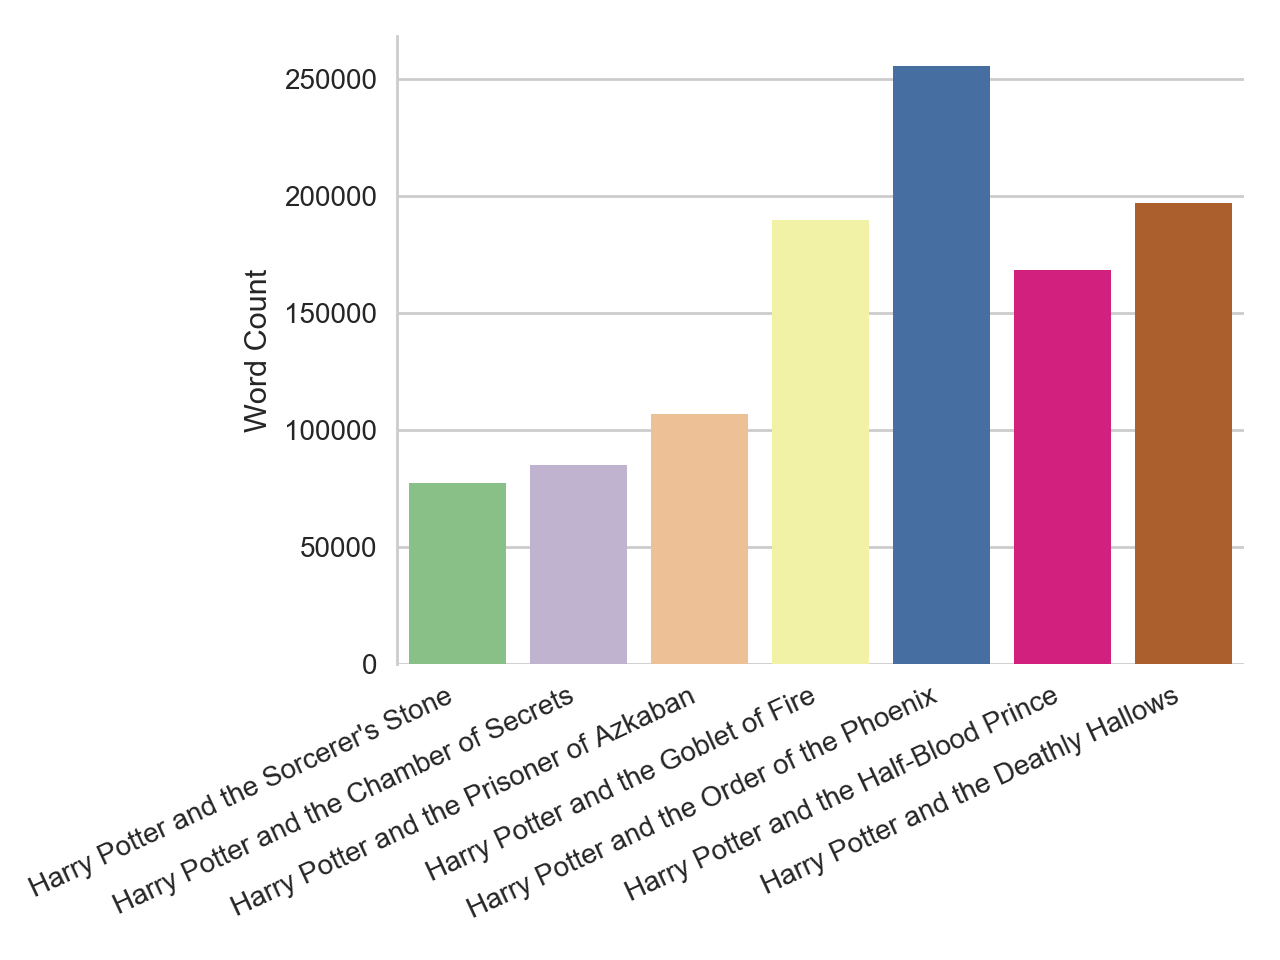

In [13]:
wc = hp.groupby(['book_number', 'book_title'])['alpha'].sum()

sns.set(style="whitegrid", context="notebook")
f = plt.figure()
sns.barplot(wc.index.get_level_values(1).values, wc, palette="Accent")

# Finalize the plot
labels = plt.gca().get_xticklabels()
plt.setp(labels, rotation=25, ha='right')
plt.ylabel('Word Count')
sns.despine(bottom=True)
plt.tight_layout(h_pad=3)

In [9]:
hp['lower'][hp['stop']].value_counts()

the            51911
and            27597
to             26857
he             22187
of             21837
a              21010
was            16175
it             14565
his            14290
you            14173
i              13535
in             12662
that           10917
had            10470
at              8708
as              7611
him             7021
on              6996
they            6817
with            6508
but             6215
for             5651
not             5484
her             5458
she             5274
what            4850
have            4540
be              4466
were            4400
out             4388
               ...  
punished           0
punishing          0
punishment         0
punishments        0
punting            0
pup                0
pupil              0
punched            0
punch              0
puked              0
pulsed             0
puking             0
pull               0
pulled             0
pullin             0
pulling            0
pulp         

In [10]:
vc = hp.token[hp.capital & ~hp.stop].value_counts()
vc[vc > 0].sum()

121227

In [11]:
(hp.lower == 'he-who-must-not-be-named').sum()

48

In [12]:
hp.to_pickle('hp.gz')